# Introduction

Text is one of the most widespread forms of sequence data. It can be understood as either a sequence of charactors or a sequence of words, but it's most common to work at level of words. Text-sequence processing includes following applications:

**Applications of deep learning for text data:**
1. Document classification
2. Articles lebelling
3. Sentiment analysis
4. Author identification
5. Question-answering
6. Language detection
7. Translation Tasks

- In true sense `deep learning models map the statistical structure of written language,` which is sufficient to solve many simple textual tasks and problems.
- Deep learning for natural-language processing is `pattern recognition applied to words, sequence, and paragraphs,` in much similar way that computer vision is pattern recognition applied to pixels.
- Deep-learning models don't take input as text like other models they only work with numeric tensors

**Three techniques to vectorize the text data:**
1. Segment text into words, and convert word into a vector
2. Segment text into charactors, and transform each chractors into a vector.
3. Extract n-grams of words, and transform each n-grams into a vector.

- There are many ways one can convert text to vector and it depends on what models one is using along with time or resources utilization.

**Typical workflow to prepare text data for machine learning models:**
1. Tokenization
2. One-Hot encoding or word indexing
3. Pad sequencing 
4. Embedding layer (Word2Vec)
5. Corresponding word vector

- In this notebook, we are going to explore and solve news classification problem to classify 41 types of news headlines and news descriptions.

**Use-case:** Such text classification models are used in `News Apps` or by reporter to classify news topics for better reach to right audience.

**Problem-statement:** Build `news classification model` using deep learning teechniques and deploy model for reporters to classify and label news articles.

*Reference: Deep learning with python by Francois Chollet*

# Table of contents:

0. [Importing libraries](#lib)
1. [Data exploration and pre-processing](#eda)

  - [Profiling report of dataset](#pp)
  - [Text data visualization](#td)
  - [Text data pre-processing](#tdp)
  
  
2. [Tokenization and vectorization](#tv)
3. [What are the word embeddings?](#we)
4. [Model training using EmbeddingLayer,RNNs and LSTMs](#rnn) 

  - [Baseline model 1](#base)
  - [What are the RNNs?](#rnets)
  - [Model training using LSTM](#model2)
  - [Loss and accuracy curve](#loss)
  
  
5. [Conclusion](#conclude)

# 0. Importing libraries

<a id="lib"></a>


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import ydata_profiling as pp
from markupsafe import escape
# from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# 1. Data exploration and pre-processing

<a id="eda"></a>


In [3]:
import pandas as pd

# Path ke file Excel
file_path = r'E:\Pembelajaran\Semester 5\PSO\FP\FinalProject_MLOps_Group1\notebook\ndf2_output.xlsx'

# Membaca file Excel
df = pd.read_excel(file_path)

df


length_of_news category_general
0       million americans roll sleeves omicrontargeted...             News
1       american airlines flyer charge ban life punch ...             News
2       funniest tweet cat dog week sept dog dont unde...    Entertainment
3       funniest tweet parent week sept accidentally p...        Lifestyle
4       woman call cop black birdwatcher lose lawsuit ...             News
...                                                   ...              ...
189406  rim ceo thorsten heins significant plan blackb...       Technology
189407  maria sharapova stun victoria azarenka austral...           Sports
189408  giants patriots jet colts among improbable sup...           Sports
189409  aldon smith arrest ers linebacker bust duicorr...           Sports
189410  dwight howard rip teammates magic loss hornets...           Sports

[189411 rows x 2 columns]

In [4]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category_general'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(189411, 2)
Unique categories: 10
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189411 entries, 0 to 189410
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   length_of_news    189397 non-null  object
 1   category_general  189411 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


## 1.1 Profiling report of dataset

<a id="pp"></a>


In [7]:
from ydata_profiling import ProfileReport

# Generate Pandas Profiling report
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 1.2 Text data visualization

<a id="td"></a>


### 1.2.1 TOP 10 Categories of News Articles

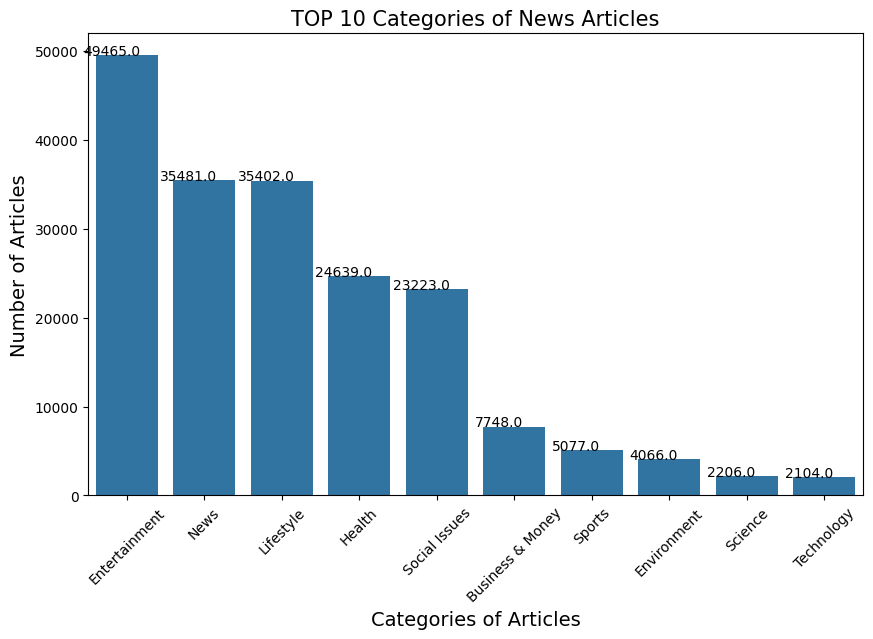

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Top categories by and number of articles per categories
cat_df = df['category_general'].value_counts().reset_index()
cat_df.columns = ['news_classes', 'numcat']

# Visualize top 10 categories and proportion of each categories in dataset
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='news_classes', y='numcat', data=cat_df[:10])  # Specify x, y, and data
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.2, p.get_height() + 0.5), ha='center')
plt.title("TOP 10 Categories of News Articles", size=15)
plt.xlabel("Categories of Articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of Articles", size=14)
plt.show()


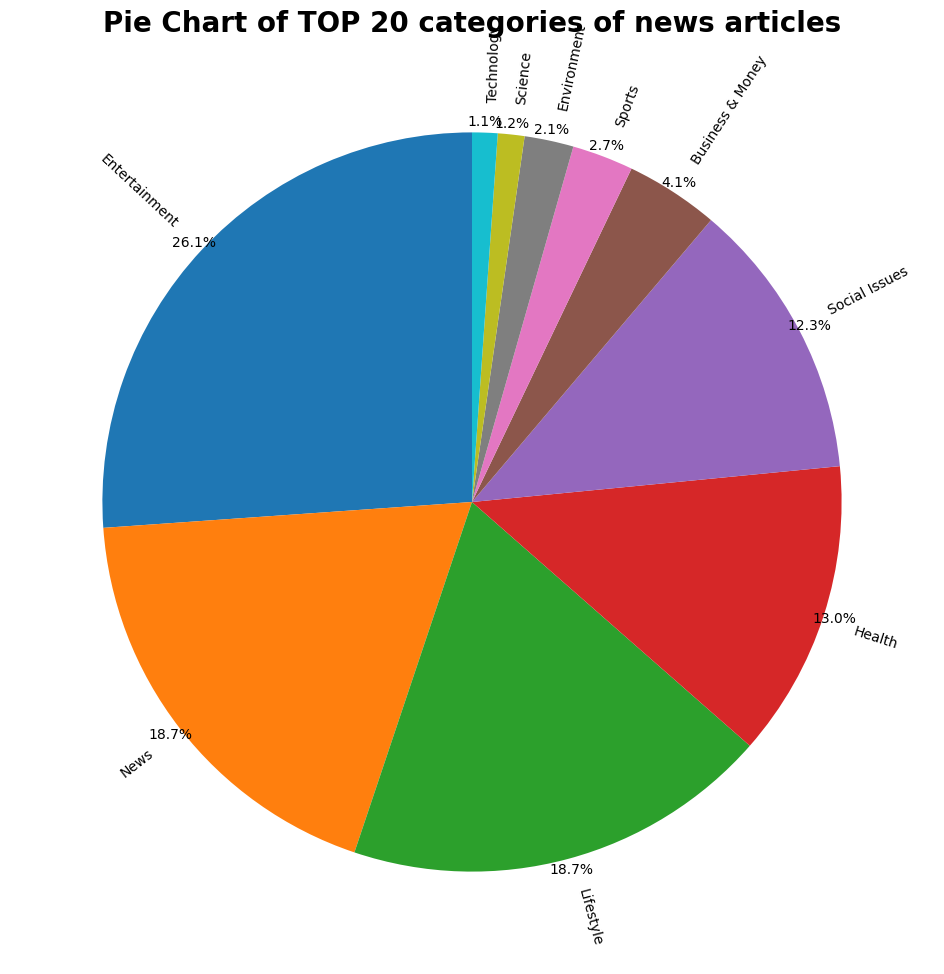

In [9]:
# plot the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:20],
            labels=cat_df['news_classes'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of TOP 20 categories of news articles", size=20, weight='bold')
plt.show()

# Preprocessing

In [11]:
# Cek jumlah data duplikat sebelum penghapusan
initial_duplicates = df.duplicated().sum()
print(f'Jumlah data duplikat sebelum penghapusan: {initial_duplicates}')

# Menghapus data duplikat
df = df.drop_duplicates()

# Cek jumlah data duplikat setelah penghapusan
final_duplicates = df.duplicated().sum()
print(f'Jumlah data duplikat setelah penghapusan: {final_duplicates}')

Jumlah data duplikat sebelum penghapusan: 743
Jumlah data duplikat setelah penghapusan: 0


In [12]:
# Menghapus baris yang berisi null value
total_empty_rows = df.isnull().any(axis=1).sum()
print(f"Total baris dengan nilai kosong: {total_empty_rows}")

# Menghapus baris yang memiliki nilai kosong (NaN) di salah satu kolom
df = df.dropna()

# Menampilkan jumlah nilai kosong (NaN) setelah penghapusan
empty_rows_after = df.isnull().sum()
print("Jumlah nilai kosong per kolom setelah penghapusan:")
print(empty_rows_after)

Total baris dengan nilai kosong: 5
Jumlah nilai kosong per kolom setelah penghapusan:
length_of_news      0
category_general    0
dtype: int64


In [13]:
# create final dataframe of combined headline and short_description
final_df = df.copy()
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

length_of_news category_general  \
0  million americans roll sleeves omicrontargeted...             News   
1  american airlines flyer charge ban life punch ...             News   
2  funniest tweet cat dog week sept dog dont unde...    Entertainment   
3  funniest tweet parent week sept accidentally p...        Lifestyle   
4  woman call cop black birdwatcher lose lawsuit ...             News   

   len_news  
0       160  
1       165  
2        62  
3       145  
4       173

In [20]:
# maximum length of news in each category
lenmax_df = final_df.groupby('category_general')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df

category_general  len_news
5              News       990
7     Social Issues       867
3            Health       704
0  Business & Money       681
4         Lifestyle       616
1     Entertainment       553
2       Environment       551
6           Science       353
9        Technology       332
8            Sports       327

In [21]:
# minimum lenght of news in each category
lenmin_df = final_df.groupby('category_general')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df

category_general  len_news
9        Technology         8
0  Business & Money         6
6           Science         5
2       Environment         5
7     Social Issues         4
3            Health         3
8            Sports         3
5              News         2
4         Lifestyle         2
1     Entertainment         1

### Wordcloud

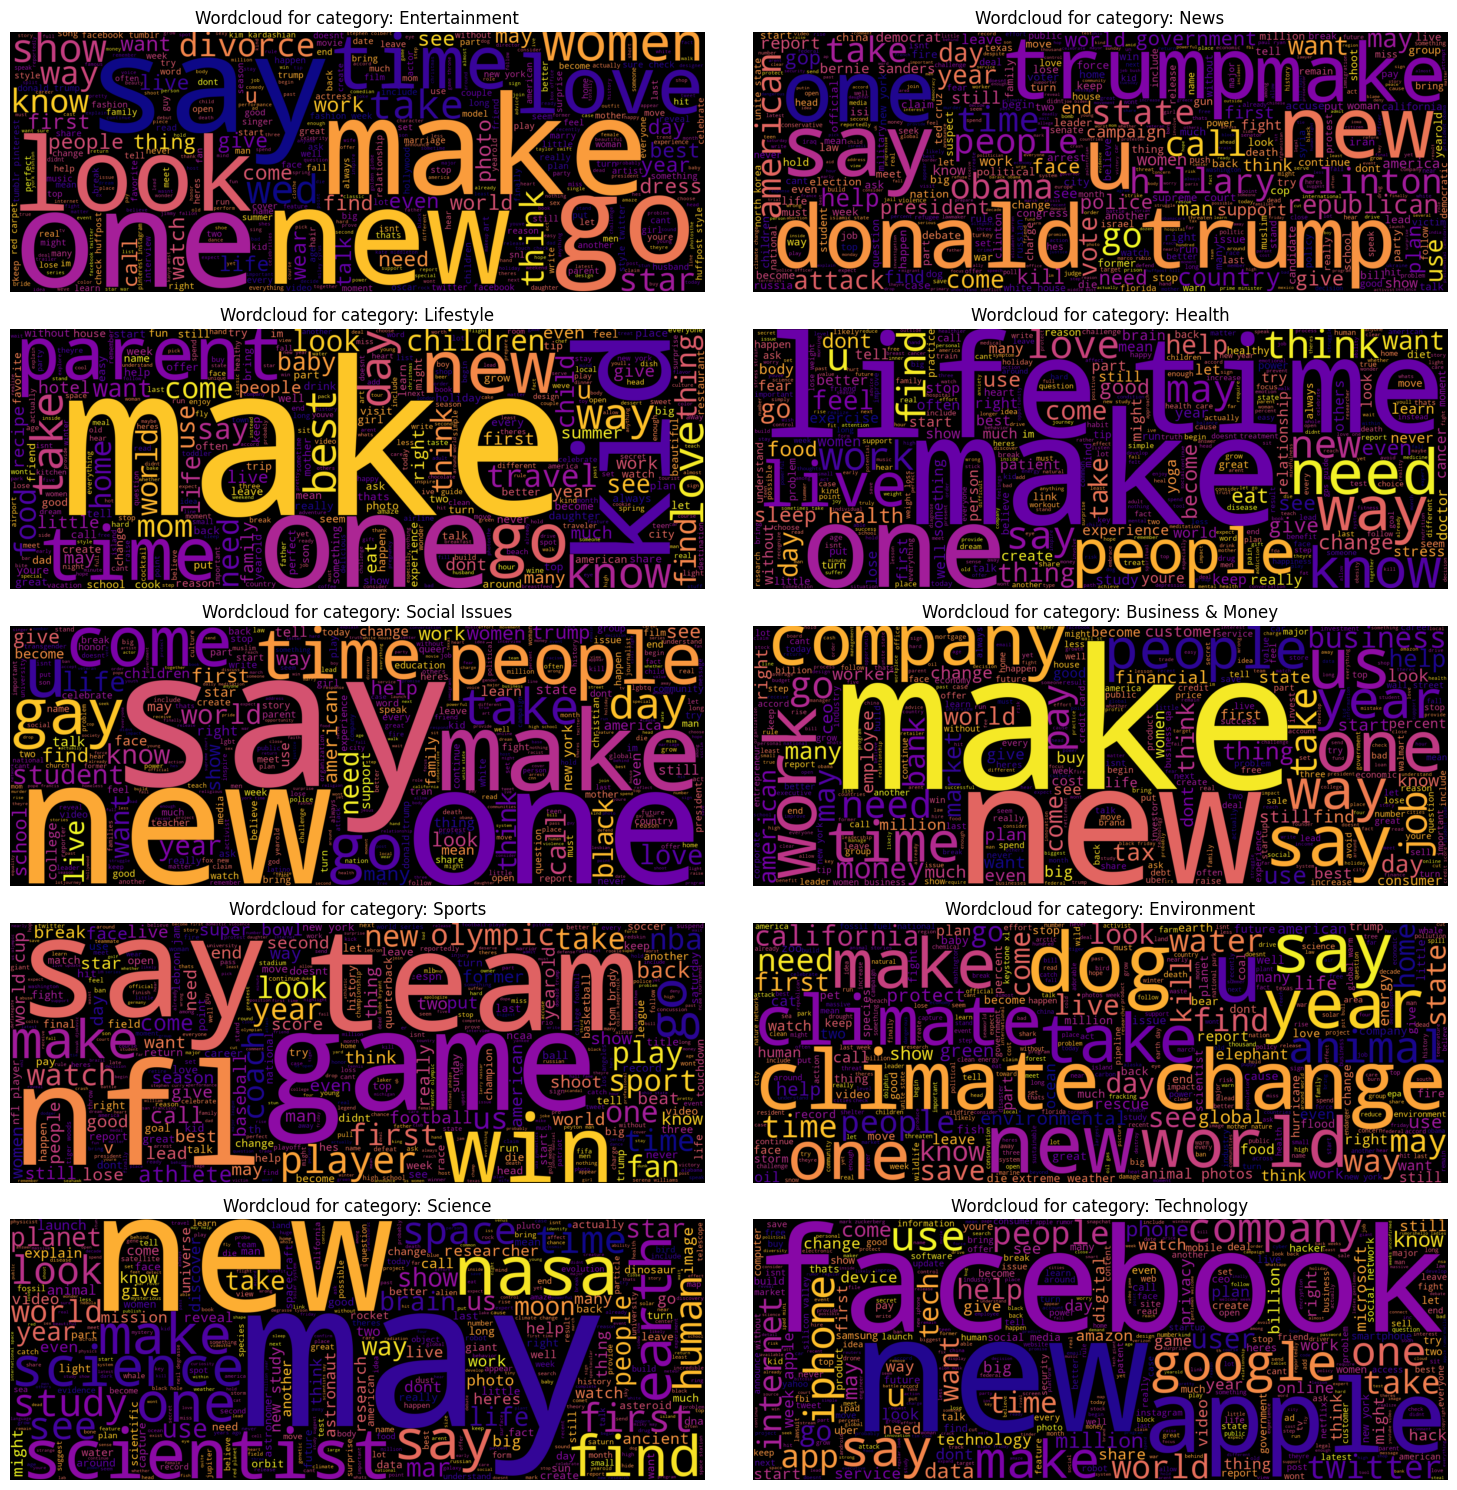

In [23]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Copy dataset
ndf = final_df.copy()

# Hapus kolom yang tidak relevan jika ada
ndf.drop('len_news', inplace=True, axis=1)

# Ambil daftar 10 kategori teratas berdasarkan category_general
categories = ndf['category_general'].value_counts().head(10).index.to_list()

# Buat list untuk menyimpan artikel berita dari setiap kategori
articles_list = []

for i in categories:
    cat_ndf = ndf[ndf['category_general'] == i]
    cat_array = cat_ndf['length_of_news'].values  # array of news articles text in each category
    articles_list.append(cat_array)

# Buat instance WordCloud
wc1 = WordCloud(
    max_words=1000, 
    min_font_size=10,
    height=600,
    width=1600,
    background_color='black',
    contour_color='black',
    colormap='plasma',
    repeat=True,
    stopwords=STOPWORDS
)

# Plot 10 WordClouds
plt.figure(figsize=(15, 15))

for idx, category in enumerate(categories):
    plt.subplot(5, 2, idx + 1)  # Atur subplot dalam layout 5x2
    cloud = wc1.generate(' '.join(articles_list[idx]))  # Gabungkan teks untuk kategori
    plt.imshow(cloud, interpolation="bilinear")
    plt.title(f"Wordcloud for category: {category}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Preprocessing

In [25]:
final_df

length_of_news category_general  \
0       million americans roll sleeves omicrontargeted...             News   
1       american airlines flyer charge ban life punch ...             News   
2       funniest tweet cat dog week sept dog dont unde...    Entertainment   
3       funniest tweet parent week sept accidentally p...        Lifestyle   
4       woman call cop black birdwatcher lose lawsuit ...             News   
...                                                   ...              ...   
189406  rim ceo thorsten heins significant plan blackb...       Technology   
189407  maria sharapova stun victoria azarenka austral...           Sports   
189408  giants patriots jet colts among improbable sup...           Sports   
189409  aldon smith arrest ers linebacker bust duicorr...           Sports   
189410  dwight howard rip teammates magic loss hornets...           Sports   

        len_news  
0            160  
1            165  
2             62  
3            145  
4            173  
...          ...  
189406       146  
189407       141  
189408       134  
189409       125  
189410       140  

[188663 rows x 3 columns]

In [26]:
category_counts = final_df['category_general'].value_counts()

# Menampilkan hasil
print(category_counts)

category_general
Entertainment       49185
News                35278
Lifestyle           35271
Health              24599
Social Issues       23194
Business & Money     7744
Sports               5076
Environment          4056
Science              2206
Technology           2054
Name: count, dtype: int64


In [31]:
# Menangani imbalanced data
from sklearn.utils import resample
import pandas as pd
import matplotlib.pyplot as plt

# Salin dataset asli ke ndf2
ndf2 = final_df.copy()

# Salin untuk dataset seimbang
balanced_df = pd.DataFrame()

# Tentukan jumlah target rata-rata untuk setiap kategori
target_size = 10000  # Sesuaikan dengan kebutuhan

# Iterasi melalui setiap kategori
for category in ndf2['category_general'].unique():
    category_data = ndf2[ndf2['category_general'] == category]
    
    if len(category_data) > target_size:
        # Under-sampling untuk kategori besar
        category_data = category_data.sample(target_size, random_state=42)
    else:
        # Over-sampling untuk kategori kecil
        category_data = resample(category_data, 
                                 replace=True, 
                                 n_samples=target_size, 
                                 random_state=42)
    
    # Gabungkan data yang telah disampling ke dalam balanced_df
    balanced_df = pd.concat([balanced_df, category_data])

# Periksa distribusi kategori setelah balancing
print(balanced_df['category_general'].value_counts())



category_general
News                10000
Entertainment       10000
Lifestyle           10000
Technology          10000
Sports              10000
Environment         10000
Social Issues       10000
Science             10000
Health              10000
Business & Money    10000
Name: count, dtype: int64


In [53]:
ndf2 = balanced_df
ndf2

length_of_news  category_general
0      jerry brown declare state emergency california...              News
1      thousands protest anticoronavirus restrictions...              News
2      find raid career criminals housewhen officials...              News
3      david lee sinnett accuse beat yearold coat han...              News
4      gun safety group urge obama take action preven...              News
...                                                  ...               ...
99995  tpp drug patent president clintonthere many se...  Business & Money
99996  bitcoins become people federal reservei believ...  Business & Money
99997  travis kalanick take leave absence post uber c...  Business & Money
99998  habit could hurt business relationshipswhile e...  Business & Money
99999  four season offer free room nyc health care wo...  Business & Money

[100000 rows x 2 columns]

Definisikan mapping kategori lama ke kategori baru
category_mapping = {
    'U.S. NEWS': 'News', 'WORLD NEWS': 'News', 'POLITICS': 'News',
    'CRIME': 'News', 'GOOD NEWS': 'News', 'WORLDPOST': 'News', 'THE WORLDPOST': 'News',
    'ENTERTAINMENT': 'Entertainment', 'COMEDY': 'Entertainment', 'ARTS': 'Entertainment',
    'CULTURE & ARTS': 'Entertainment', 'STYLE': 'Entertainment', 'STYLE & BEAUTY': 'Entertainment',
    'WOMEN': 'Entertainment', 'FIFTY': 'Entertainment', 'DIVORCE': 'Entertainment', 'WEDDINGS': 'Entertainment',
    'SPORTS': 'Sports', 'TECH': 'Technology', 'SCIENCE': 'Science',
    'WELLNESS': 'Health', 'HEALTHY LIVING': 'Health', 'ENVIRONMENT': 'Environment',
    'GREEN': 'Environment', 'HOME & LIVING': 'Lifestyle', 'TRAVEL': 'Lifestyle',
    'FOOD & DRINK': 'Lifestyle', 'TASTE': 'Lifestyle', 'PARENTS': 'Lifestyle',
    'PARENTING': 'Lifestyle', 'BUSINESS': 'Business & Money', 'MONEY': 'Business & Money',
    'QUEER VOICES': 'Social Issues', 'BLACK VOICES': 'Social Issues', 'LATINO VOICES': 'Social Issues',
    'IMPACT': 'Social Issues', 'RELIGION': 'Social Issues', 'MEDIA': 'Social Issues',
    'EDUCATION': 'Social Issues', 'COLLEGE': 'Social Issues'
}

In [51]:
# Menampilkan kategori unik setelah filter
unique_categories = ndf2['category_general'].unique()
print("Unique categories:", unique_categories)


Unique categories: ['News' 'Entertainment' 'Lifestyle' 'Technology' 'Sports' 'Environment'
 'Social Issues' 'Science' 'Health' 'Business & Money']


In [54]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Pastikan stopwords dan lemmatizer tersedia
nltk.download('stopwords')
nltk.download('wordnet')

STOPWORDS = set(stopwords.words('english'))  # Menggunakan stopwords dari nltk

def datacleaning(text):
    # Regex patterns
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    
    # Substitusi dengan regex
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub(r"\d+", "", text)  # Raw string untuk \d+
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    # Removing stop-words
    text = [word for word in text.split() if word not in STOPWORDS]
    
    # Word lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word, 'v') for word in text]
    
    return ' '.join(text)


[nltk_data] Downloading package stopwords to C:\Users\Annisa
[nltk_data]     Fadila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Annisa
[nltk_data]     Fadila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
# Pastikan kolom 'length_of_news' memiliki teks
ndf2.reset_index(drop=True, inplace=True)

# apply datacleaning function to column 'length_of_news'
ndf2['length_of_news'] = ndf2['length_of_news'].apply(datacleaning)


In [57]:
# length of total characters before and after cleaning text data
old_length = ndf['length_of_news'].apply(len).sum()
new_length = ndf2['length_of_news'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 22762789
New chracters length of text data: 12071078


In [58]:
# length of total words before and after cleaning text data
old_text = ndf['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = ndf2['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 3249589
New word length of text data: 1710972


# 2. Tokenization and vectorization

<a id="tv"></a>


### Some of the most common NLP terminologies

**1. Document**
- Each and every training example used in text dataset known as a Document.

**2. Corpus**
- Collections of documents called as a corpus of text data

**3. Vocabulary(BoW)**
- Vocabulary or Bag-of-words is nothing but number of unique words are present in text corpus.

**4. Stop words**
- Stop words are those used most commonly in any language, e.g. 'the', 'a', etc. they do not form any meaning to the context of the text

**5. N-grams**
- N-grams is text representation in form of N words sequences to extract meaning and context out of each sentences or paragraphs.

**6. Tokenization**
- It's an early step in NLP process to split text sentences into smaller words or tokens.

**7. Vectorization**
- Machine do not understand text or words, so text data or tokens must be converted to corrospinding word index or word vectors in order process text and build models. process of converting tokenized words into numerical vectors called as a vectorization.

### One-hot encoding and word-indexing example on chunk of data

In [59]:
# tokenization and vectorization workflow
# word level one-hot encoding for sample data

samples = list(ndf2['length_of_news'][:5].values)  # samples of first 5 documents of out dataset

token_index = {}  # builds an index of tokens in the data
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # assigning unique index to each unique words
            
max_length = 15

results = np.zeros(shape=(len(samples),   # results will be stored in this array
                          max_length,
                          max(token_index.values()) +1)) 

print("Shape of stored results array:", results.shape)
print("Token index of unique words: \n", token_index)

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape of stored results array: (5, 15, 88)
Token index of unique words: 
 {'jerry': 1, 'brown': 2, 'declare': 3, 'state': 4, 'emergency': 5, 'california': 6, 'wildfires': 7, 'ragecalifornia': 8, 'gov': 9, 'blaze': 10, 'counties': 11, 'across': 12, 'golden': 13, 'thousands': 14, 'protest': 15, 'anticoronavirus': 16, 'restrictions': 17, 'germany': 18, 'weekendthe': 19, 'march': 20, 'attract': 21, 'mix': 22, 'crowd': 23, 'civil': 24, 'right': 25, 'activists': 26, 'people': 27, 'oppose': 28, 'vaccinations': 29, 'well': 30, 'neonazis': 31, 'members': 32, 'farright': 33, 'find': 34, 'raid': 35, 'career': 36, 'criminals': 37, 'housewhen': 38, 'officials': 39, 'house': 40, 'detroit': 41, 'stumble': 42, 'quite': 43, 'haul': 44, 'wayne': 45, 'county': 46, 'sheriffs': 47, 'deputies': 48, 'bureau': 49, 'alcohol': 50, 'david': 51, 'lee': 52, 'sinnett': 53, 'accuse': 54, 'beat': 55, 'yearold': 56, 'coat': 57, 'hangersinnett': 58, 'charge': 59, 'aggravate': 60, 'child': 61, 'abuse': 62, 'years': 63, 

### One-hot encoding and indexing of train and test data

In [60]:
# one hot encoding using keras tokenizer and pad sequencing
X = ndf2['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(ndf2['category_general'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20)

word_index = tokenizer.word_index
max_words = 150000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 130 # max length of sequence 
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print("Length of word index:", total_words)

shape of input data:  (100000,)
shape of target variable:  (100000,)
Length of word index: 90489


# 3. What are the Wordembeddings?

<a id="we"></a>


> A word embedding is a learned representation for text where words that have the same meaning and save similar representation

Reference:- [Machinelearningmastery](https://machinelearningmastery.com/what-are-word-embeddings/)

- This approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on chllengin NLP problems
- Word embeddings are alternative to one-hot encoding along with dimensionality reduction

> One-hot word vectors - Sparse, High-dimensional and Hard-coded 

> Word embeddings - Dense, Lower-Dimensional and Learned from the data

- Keras library has embeddings layer which does word representation of given text corpus 

**tf.keras.layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs
)**

**Key Arguments:**

1) input_dim - Size of vocabulary - length of word index

2) output_dim - Output dimention of word representation

3) input-length - max input sequence length of document

**Visual depiction of word embeddings:-**

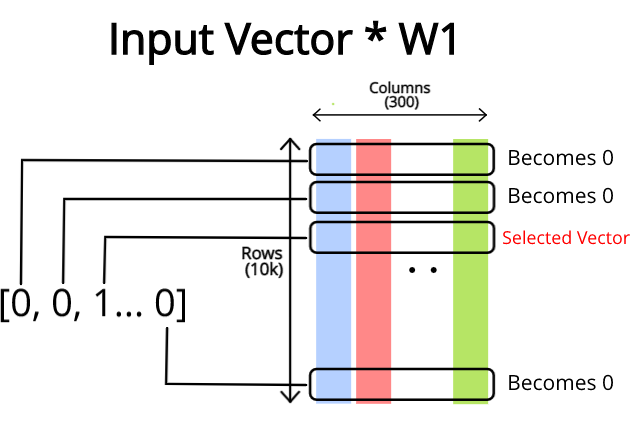

# Pembuatan Model

In [135]:
# Model definition
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=total_words, output_dim=128, input_length=maxlen))

# Bidirectional LSTM with dropout and recurrent dropout
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model.add(Bidirectional(LSTM(64, activation='tanh', dropout=0.3, recurrent_dropout=0.3)))

# Fully connected layer
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(10, activation='softmax'))  # 10 classes sesuai kategori

# Build model
model.build(input_shape=(None, maxlen))

# Print model summary
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 130, 128)       │    19,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_33                │ (None, 130, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_34                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,406,538 (74.03 MB)

 Trainable params: 19,406,538 (74.03 MB)

 Non-trainable params: 0 (0.00 B)

In [136]:
# Compile model
model.compile(
    loss='categorical_crossentropy',  # Loss function untuk multi-class classification
    optimizer='adam',                # Optimizer
    metrics=['accuracy']             # Ukuran performa
)


In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks: Early Stopping dan Reduce LR on Plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

# Train the model
history = model.fit(
    train_padseq, y_train,          # Data training
    validation_split=0.2,           # 20% data untuk validasi
    epochs=20,                      # Maksimal 20 epoch
    batch_size=64,                  # Ukuran batch
    callbacks=[early_stopping, reduce_lr],  # Gunakan callbacks
    verbose=1                       # Menampilkan progress training
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 170s 163ms/step - accuracy: 0.3353 - loss: 1.8291 - val_accuracy: 0.6901 - val_loss: 0.9526 - learning_rate: 0.0010
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 164s 164ms/step - accuracy: 0.7751 - loss: 0.7271 - val_accuracy: 0.7501 - val_loss: 0.8125 - learning_rate: 0.0010
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 164s 164ms/step - accuracy: 0.8832 - loss: 0.3895 - val_accuracy: 0.7574 - val_loss: 0.8447 - learning_rate: 0.0010
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 162s 162ms/step - accuracy: 0.9326 - loss: 0.2279 - val_accuracy: 0.7560 - val_loss: 0.9441 - learning_rate: 0.0010
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 164s 164ms/step - accuracy: 0.9630 - loss: 0.1315 - val_accuracy: 0.7615 - val_loss: 1.0841 - learning_rate: 5.0000e-04


In [138]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_padseq, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}"
      )

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7442 - loss: 0.8282
Test Loss: 0.8222466111183167
Test Accuracy: 0.746649980545044


In [145]:
model.save("model2(balancing).h5")

# Cek

In [146]:
import pickle

# Simpan tokenizer ke file
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer berhasil disimpan.")


Tokenizer berhasil disimpan.


In [ ]:
import pickle

# Simpan LabelEncoder ke file
with open('label_encoder2.pkl', 'wb') as file:
    pickle.dump(encoder, file)

print("LabelEncoder berhasil disimpan ke file 'label_encoder2.pkl'")


In [141]:
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Muat Tokenizer, LabelEncoder, dan Model
with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

with open('label_encoder2.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

model = load_model('model2(balancing).h5')

# 2. Proses Input Text
input_text = ["million americans roll sleeves omicrontargeted covid boostershealth experts say early predict whether demand would match million dose new boosters us order fall"]

# Tokenisasi dan Padding
input_seq = tokenizer.texts_to_sequences(input_text)
input_padseq = pad_sequences(input_seq, maxlen=130)  # Sesuaikan maxlen dengan model Anda

# 3. Prediksi Kategori
predictions = model.predict(input_padseq)

# Ambil Kategori dengan Probabilitas Tertinggi
predicted_class_index = np.argmax(predictions, axis=1)  # Index kategori
predicted_class = label_encoder.inverse_transform(predicted_class_index)  # Label kategori

# 4. Tampilkan Hasil
print("Prediksi Kategori:", predicted_class[0])
print("Probabilitas:", predictions[0][predicted_class_index[0]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediksi Kategori: Environment
Probabilitas: 0.4820219


In [147]:

model = load_model('model2(balancing).h5')
# Prediksi kategori pada data test
y_pred_prob = model.predict(test_padseq)  # Prediksi probabilitas
y_pred = y_pred_prob.argmax(axis=1)       # Ambil indeks kelas dengan probabilitas tertinggi


550/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

In [143]:
# Convert y_test back to numerical labels
y_test_classes = y_test.argmax(axis=1)

comparison_df = pd.DataFrame({
    'Actual': y_test_classes,
    'Predicted': y_pred
})

# Tambahkan nama kategori jika diperlukan
comparison_df['Actual Category'] = comparison_df['Actual'].apply(lambda x: encoder.classes_[x])
comparison_df['Predicted Category'] = comparison_df['Predicted'].apply(lambda x: encoder.classes_[x])

# Tampilkan beberapa contoh
print(comparison_df.head(20))  # Tampilkan 20 baris pertama


    Actual  Predicted   Actual Category Predicted Category
0        8          8            Sports             Sports
1        2          2       Environment        Environment
2        9          9        Technology         Technology
3        5          5              News               News
4        2          2       Environment        Environment
5        8          8            Sports             Sports
6        3          5            Health               News
7        0          0  Business & Money   Business & Money
8        0          0  Business & Money   Business & Money
9        9          9        Technology         Technology
10       9          9        Technology         Technology
11       8          8            Sports             Sports
12       1          1     Entertainment      Entertainment
13       3          0            Health   Business & Money
14       9          9        Technology         Technology
15       0          0  Business & Money   Business & Mon

In [144]:
# Total prediksi yang benar
total_correct = (y_test_classes == y_pred).sum()

# Total prediksi yang salah
total_incorrect = (y_test_classes != y_pred).sum()

print(f"Total Correct Predictions: {total_correct}")
print(f"Total Incorrect Predictions: {total_incorrect}")


Total Correct Predictions: 14933
Total Incorrect Predictions: 5067
